In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈

# GPU 선택 -> '1': 두 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '가렵다',
    '기절',
    '부러지다',
    '어제',
    '어지러움'
]

data = np.concatenate([
    np.load('dataset/4_seq_20_가렵다_1714028633.npy'),
    np.load('dataset/4_seq_20_기절_1714028778.npy'),
    np.load('dataset/4_seq_20_부러지다_1714028916.npy'),
    np.load('dataset/4_seq_20_어제_1714029055.npy'),
    np.load('dataset/4_seq_20_어지러움_1714029193.npy'),
], axis=0)

data.shape
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(9908, 30, 268)

In [3]:
# 시퀀스의 마지막 열 제외한 모든 열 가져와 할당
# 첫 번째 행의 마지막 열은 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
print(labels.shape)
print(np.unique(labels))    # 레이블 값 출력

(9908, 30, 268)
(9908,)
[0. 1. 2. 3. 4.]


In [4]:
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(9908, 5)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# train data : validation data : test data = 6 : 2 : 2
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(5944, 30, 267) (5944, 5)
(1982, 30, 267) (1982, 5)
(1982, 30, 267) (1982, 5)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                84992     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 87237 (340.77 KB)
Trainable params: 87237 (340.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, verbose=1, mode='auto')
    ]
)

Epoch 1/100


178/186 [===========================>..] - ETA: 0s - loss: 1.6091 - acc: 0.2110
Epoch 1: val_acc improved from -inf to 0.20131, saving model to models\model.h5
186/186 [==============================] - 3s 9ms/step - loss: 1.6091 - acc: 0.2106 - val_loss: 1.6096 - val_acc: 0.2013 - lr: 0.0010
Epoch 2/100
 20/186 [==>...........................] - ETA: 1s - loss: 1.6091 - acc: 0.2125

c:\Users\_\anaconda3\envs\py3_9_11\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/186 [===========================>..] - ETA: 0s - loss: 1.6086 - acc: 0.2150
Epoch 2: val_acc did not improve from 0.20131
186/186 [==============================] - 1s 8ms/step - loss: 1.6086 - acc: 0.2148 - val_loss: 1.6099 - val_acc: 0.2013 - lr: 0.0010
Epoch 3/100
185/186 [============================>.] - ETA: 0s - loss: 1.6084 - acc: 0.2152
Epoch 3: val_acc did not improve from 0.20131
186/186 [==============================] - 1s 8ms/step - loss: 1.6084 - acc: 0.2148 - val_loss: 1.6102 - val_acc: 0.2013 - lr: 0.0010
Epoch 4/100
183/186 [============================>.] - ETA: 0s - loss: 1.6084 - acc: 0.2141
Epoch 4: val_acc did not improve from 0.20131
186/186 [==============================] - 1s 8ms/step - loss: 1.6083 - acc: 0.2148 - val_loss: 1.6103 - val_acc: 0.2013 - lr: 0.0010
Epoch 5/100
186/186 [==============================] - ETA: 0s - loss: 1.6084 - acc: 0.2148
Epoch 5: val_acc did not improve from 0.20131
186/186 [==============================] - 1s 8ms/step - l

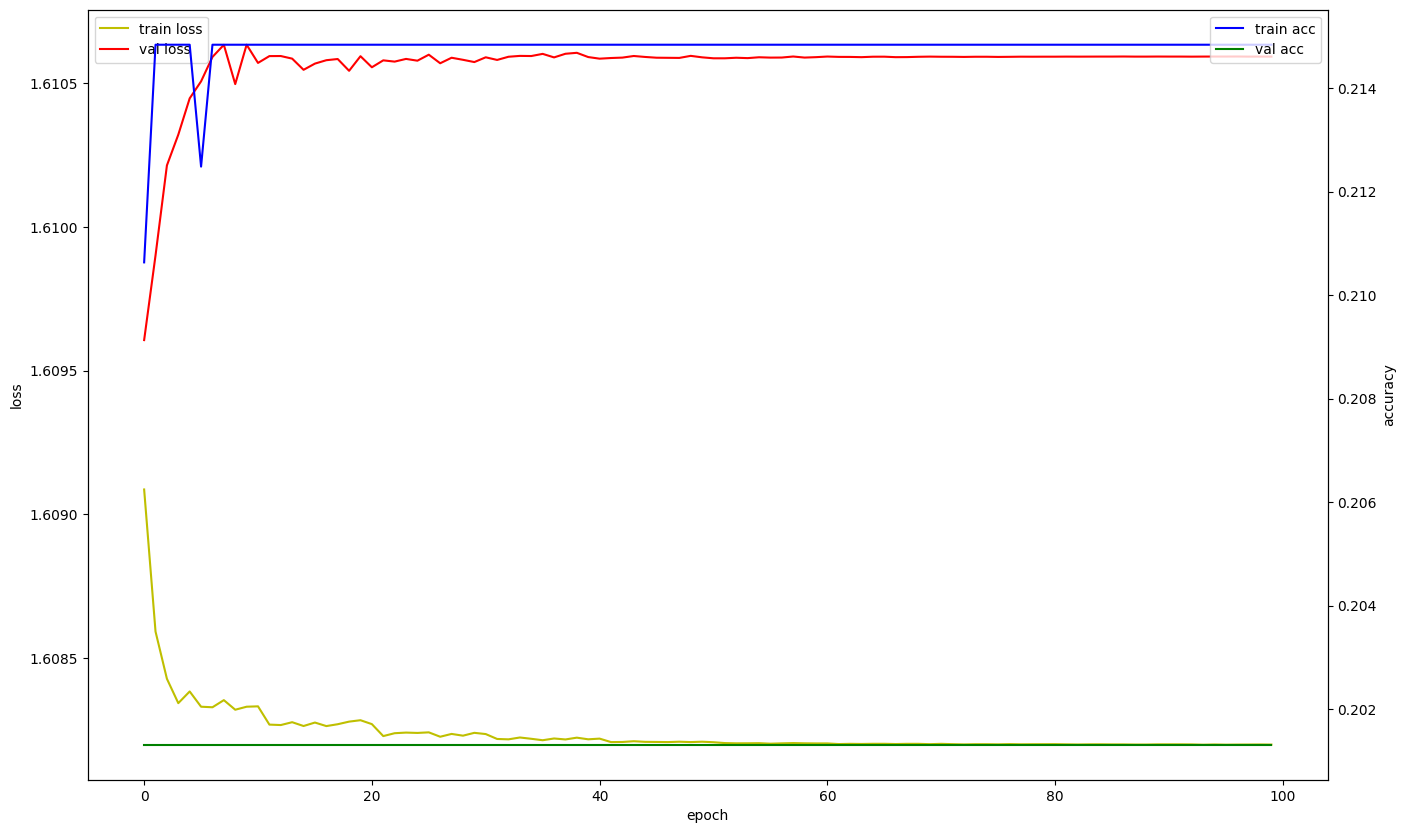

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_acc}")

y_pred = model.predict(x_val)

# 다중 레이블 혼동 행렬로 모델 평가
# [[True Negative, False Positive],
# [False Negative, True Positive]]
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

62/62 [==============================] - 0s 3ms/step - loss: 1.6094 - acc: 0.1953
테스트 손실: 1.6093828678131104
테스트 정확도: 0.19525732100009918
62/62 [==============================] - 0s 3ms/step


array([[[   0, 1583],
        [   0,  399]],

       [[1585,    0],
        [ 397,    0]],

       [[1582,    0],
        [ 400,    0]],

       [[1579,    0],
        [ 403,    0]],

       [[1599,    0],
        [ 383,    0]]], dtype=int64)